# Problem Set 7
## Ying Sun

In [1]:
import pandas as pd
import seaborn as sb
from pylab import rcParams
rcParams['figure.figsize'] = 8,6
sb.set_style('whitegrid')
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, mean_squared_error
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import LSQUnivariateSpline

## 1. Multinomial logistic regression and cross validation

In [2]:
# Load the data
strongdrink = pd.read_csv("strongdrink.txt")
strongdrink['const'] = 1
strongdrink.head()

,cultivar,alco,malic,ash,alk,magn,tot_phen,flav,nonfl_phen,proanth,color_int,hue,OD280rat,proline,const
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1


### (a) Estimate multinomial logistic regression model

In [3]:
# Check for missing values
strongdrink.isnull().sum()

cultivar      0
alco          0
malic         0
ash           0
alk           0
magn          0
tot_phen      0
flav          0
nonfl_phen    0
proanth       0
color_int     0
hue           0
OD280rat      0
proline       0
const         0
dtype: int64

In [4]:
# Check for categories
strongdrink["cultivar"].value_counts()

2    71
1    59
3    46
Name: cultivar, dtype: int64

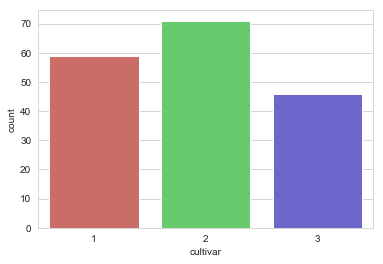

In [5]:
sb.countplot(x='cultivar', data=strongdrink, palette='hls')

In [6]:
# Seperate the data into training data and test data
y = strongdrink["cultivar"]
X = strongdrink[["alco","malic","tot_phen","color_int"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=20)

In [7]:
MultLogReg = LogisticRegression(random_state=20, solver='lbfgs',multi_class='multinomial', max_iter=5000).fit(X_train, y_train)
print(MultLogReg.coef_)
print(MultLogReg.intercept_)

[[ 1.7017346  -0.26578768  1.22410097  0.02250682]
 [-1.4662973  -0.33295173  0.66355614 -0.92268167]
 [-0.2354373   0.59873941 -1.8876571   0.90017485]]
[-24.02761754  22.78073348   1.24688406]


In [8]:
y_pred = MultLogReg.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.87      1.00      0.93        13
           2       1.00      0.90      0.95        21
           3       1.00      1.00      1.00        10

   micro avg       0.95      0.95      0.95        44
   macro avg       0.96      0.97      0.96        44
weighted avg       0.96      0.95      0.96        44



In [9]:
print('Validation set MSE = ', mean_squared_error(y_test,y_pred))

Validation set MSE =  0.045454545454545456


In [10]:
print('j = 1:', '\n b0 =', MultLogReg.intercept_[0], '   b1 =', MultLogReg.coef_[0][0],
      '\n b2 =', MultLogReg.coef_[0][1], '  b3 =', MultLogReg.coef_[0][2],
      '    b4 =', MultLogReg.coef_[0][3])
print('\n')
print('j = 2:','\n b0 =', MultLogReg.intercept_[1], '    b1 =', MultLogReg.coef_[1][0],
      '\n b2 =', MultLogReg.coef_[1][1], '  b3 =', MultLogReg.coef_[1][2],
      '  b4 =', MultLogReg.coef_[1][3])

j = 1: 
 b0 = -24.02761753606448    b1 = 1.7017345994125876 
 b2 = -0.265787681951153   b3 = 1.224100966414856     b4 = 0.02250681663699591


j = 2: 
 b0 = 22.780733477537513     b1 = -1.4662973034400184 
 b2 = -0.3329517272902513   b3 = 0.6635561354919529   b4 = -0.9226816655303192


The error rates(1 - precision) for each cultivar are as follows:  
category 1: error rate = 0.13  
category 2: error rate = 0  
category 3: error rate = 0  
Based above results, the model is best at predicting cultivar 3 because of its highest F1-score. Cultivar 2 is the category with the most observations. So the most accurately predicted category is not the one with the most observations.

### (b) Perform a leave-one-out cross validation (LOOCV) with the model from part (a)

In [11]:
Xvals = X.values
yvals = y.values
N_loo = Xvals.shape[0]
loo = LeaveOneOut()
loo.get_n_splits(Xvals)

176

In [12]:
MSE_vec = np.zeros(N_loo)
MSE_err = np.zeros(N_loo)
y_test_vec = np.zeros(N_loo)
y_pred_vec = np.zeros(N_loo)


for train_index, test_index in loo.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    y_pred_vec[test_index] = y_pred
    y_test_vec[test_index] = y_test
    MSE_vec[test_index] = (y_test - y_pred) ** 2
    MSE_err[test_index] = (y_test != y_pred).astype(int)

In [13]:
print(classification_report(y_test_vec, y_pred_vec))

              precision    recall  f1-score   support

         1.0       0.90      0.93      0.92        59
         2.0       0.91      0.90      0.91        71
         3.0       0.96      0.93      0.95        46

   micro avg       0.92      0.92      0.92       176
   macro avg       0.92      0.92      0.92       176
weighted avg       0.92      0.92      0.92       176



In [14]:
print('The error rate of category 1 is', 1.00-0.90)
print('The error rate of category 2 is', 1.00-0.91)
print('The error rate of category 3 is', 1.00-0.96)

The error rate of category 1 is 0.09999999999999998
The error rate of category 2 is 0.08999999999999997
The error rate of category 3 is 0.040000000000000036


In [15]:
print('test estimate MSE loocv=', MSE_err.mean(),', test estimate MSE standard err=', MSE_err.std())

test estimate MSE loocv= 0.07954545454545454 , test estimate MSE standard err= 0.2705882022679695


Compared with part(a), the error rate for category 1 become smaller but category 2 and category 3 become larger. So it's worse than the result from part(a).

### (c) Perform a k-fold cross validation in which the data are divided into k = 4 groups.

In [16]:
k = 4
kf = KFold(n_splits=k, random_state=10, shuffle=True)
kf.get_n_splits(Xvals)
N = strongdrink.shape[0]
MSE_vec_kf = np.zeros(k)
classify_kf = np.empty((N, 2))

k_ind = 0
for train_index, test_index in kf.split(Xvals):
    X_train, X_test = Xvals[train_index], Xvals[test_index]
    y_train, y_test = yvals[train_index], yvals[test_index]
    LogReg = LogisticRegression(multi_class='multinomial',
                                solver='newton-cg')
    LogReg.fit(X_train, y_train)
    y_pred = LogReg.predict(X_test)
    MSE_vec_kf[k_ind] = (y_test != y_pred).mean()
    classify_kf[test_index,0:1] = np.array([y_test]).reshape((44,1))
    classify_kf[test_index,1] = y_pred
    k_ind += 1

err_rate_kf = pd.DataFrame({"error rate":[0.13, 0.09, 0.04]},index = \
        ["cultivar = 1", "cultivar = 2", "cultivar = 3"])
for i in range(0,4):
    print('MSE for test set', i, ' is', MSE_vec_kf[i])
print('The test estimate (average) MSE k-fold is', MSE_vec_kf.mean(),'\n')
print('The final result is\n',classification_report(classify_kf[:,0], classify_kf[:,1]))
print('\nThe error rates are: \n', err_rate_kf)


MSE for test set 0  is 0.1590909090909091
MSE for test set 1  is 0.11363636363636363
MSE for test set 2  is 0.045454545454545456
MSE for test set 3  is 0.045454545454545456
The test estimate (average) MSE k-fold is 0.09090909090909091 

The final result is
               precision    recall  f1-score   support

         1.0       0.87      0.93      0.90        59
         2.0       0.91      0.87      0.89        71
         3.0       0.96      0.93      0.95        46

   micro avg       0.91      0.91      0.91       176
   macro avg       0.91      0.91      0.91       176
weighted avg       0.91      0.91      0.91       176


The error rates are: 
               error rate
cultivar = 1        0.13
cultivar = 2        0.09
cultivar = 3        0.04


The error rates are larger than part (a) and part(b), so the result is worse. 

## 2. Splines and interpolation

### (a) Create a scatterplot 

In [17]:
df = pd.read_csv('data/CoolIndex.txt', header=None, names=['Age', 'CoolIndex'])
df.head()

,Age,CoolIndex
0,11.0,10.981602
1,11.0,11.364925
2,11.0,10.190227
3,11.0,9.903725
4,11.0,8.997918


<IPython.core.display.Javascript object>


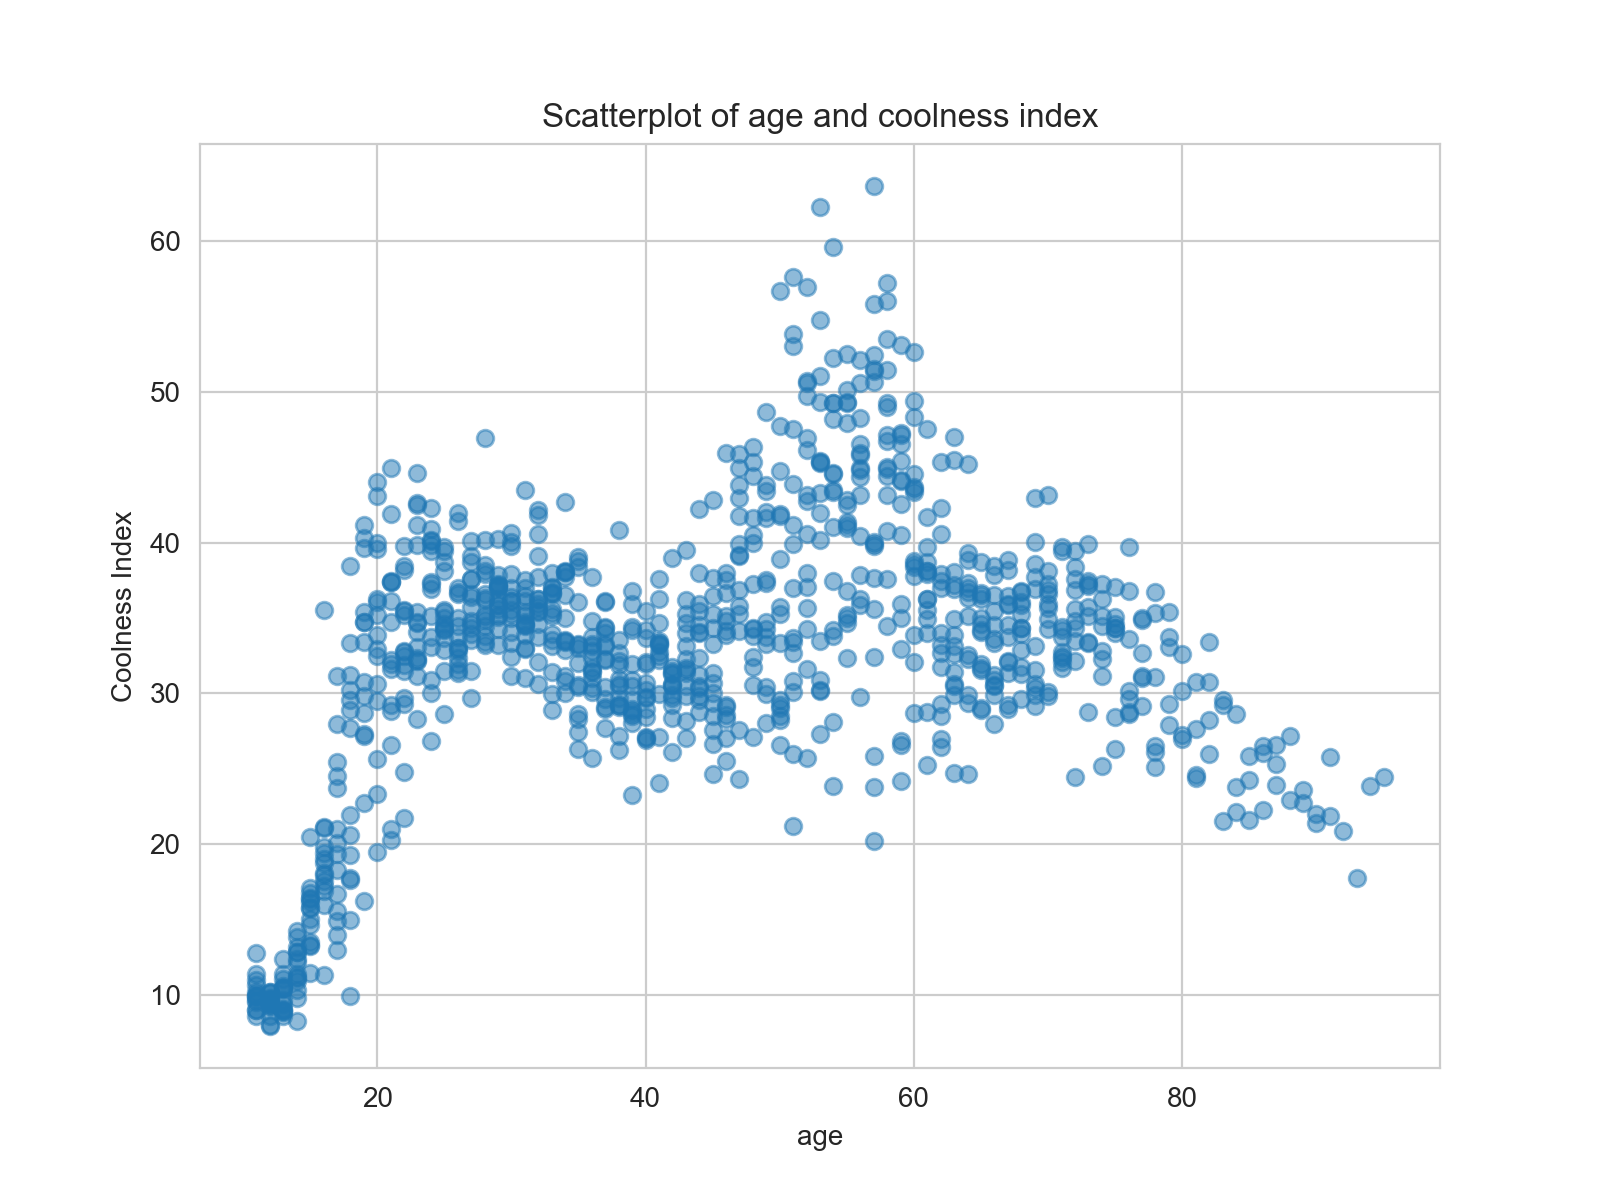

In [18]:
%matplotlib notebook
plt.scatter(df.Age,df.CoolIndex,alpha=0.5)
plt.xlabel("age")
plt.ylabel("Coolness Index")
plt.title("Scatterplot of age and coolness index")
plt.show()

### (b) Use ordinary least squares (OLS) regression to fit a stepwise function to these data. 

In [19]:
df["y1"]=np.where((df.Age>=11) & (df.Age<22),1,0)
df["y2"]=np.where((df.Age>=22) & (df.Age<40),1,0)
df["y3"]=np.where((df.Age>=40) & (df.Age<59),1,0)
df["y4"]=np.where((df.Age>=59) & (df.Age<77),1,0)
df["y5"]=np.where((df.Age>=77) & (df.Age<=95),1,0)
X = df[["y1","y2","y3","y4","y5"]]
res = sm.OLS(df.CoolIndex, X).fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              CoolIndex   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.427
Method:                 Least Squares   F-statistic:                     178.7
Date:                Mon, 25 Feb 2019   Prob (F-statistic):          3.73e-114
Time:                        02:27:13   Log-Likelihood:                -3214.5
No. Observations:                 956   AIC:                             6439.
Df Residuals:                     951   BIC:                             6463.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
y1            20.1025      0.562     35.746      0.0

In [20]:
print("The estimated step function values for each bin are as follows:")
print(res.params)

The estimated step function values for each bin are as follows:
y1    20.102457
y2    34.475788
y3    37.635105
y4    35.225400
y5    27.296378
dtype: float64


In [21]:
print("The predicted coolness of a 73-year old from the stepwise function is:")
print(float(res.predict([0,0,0,1,0])))

The predicted coolness of a 73-year old from the stepwise function is:
35.22540004024275


<IPython.core.display.Javascript object>


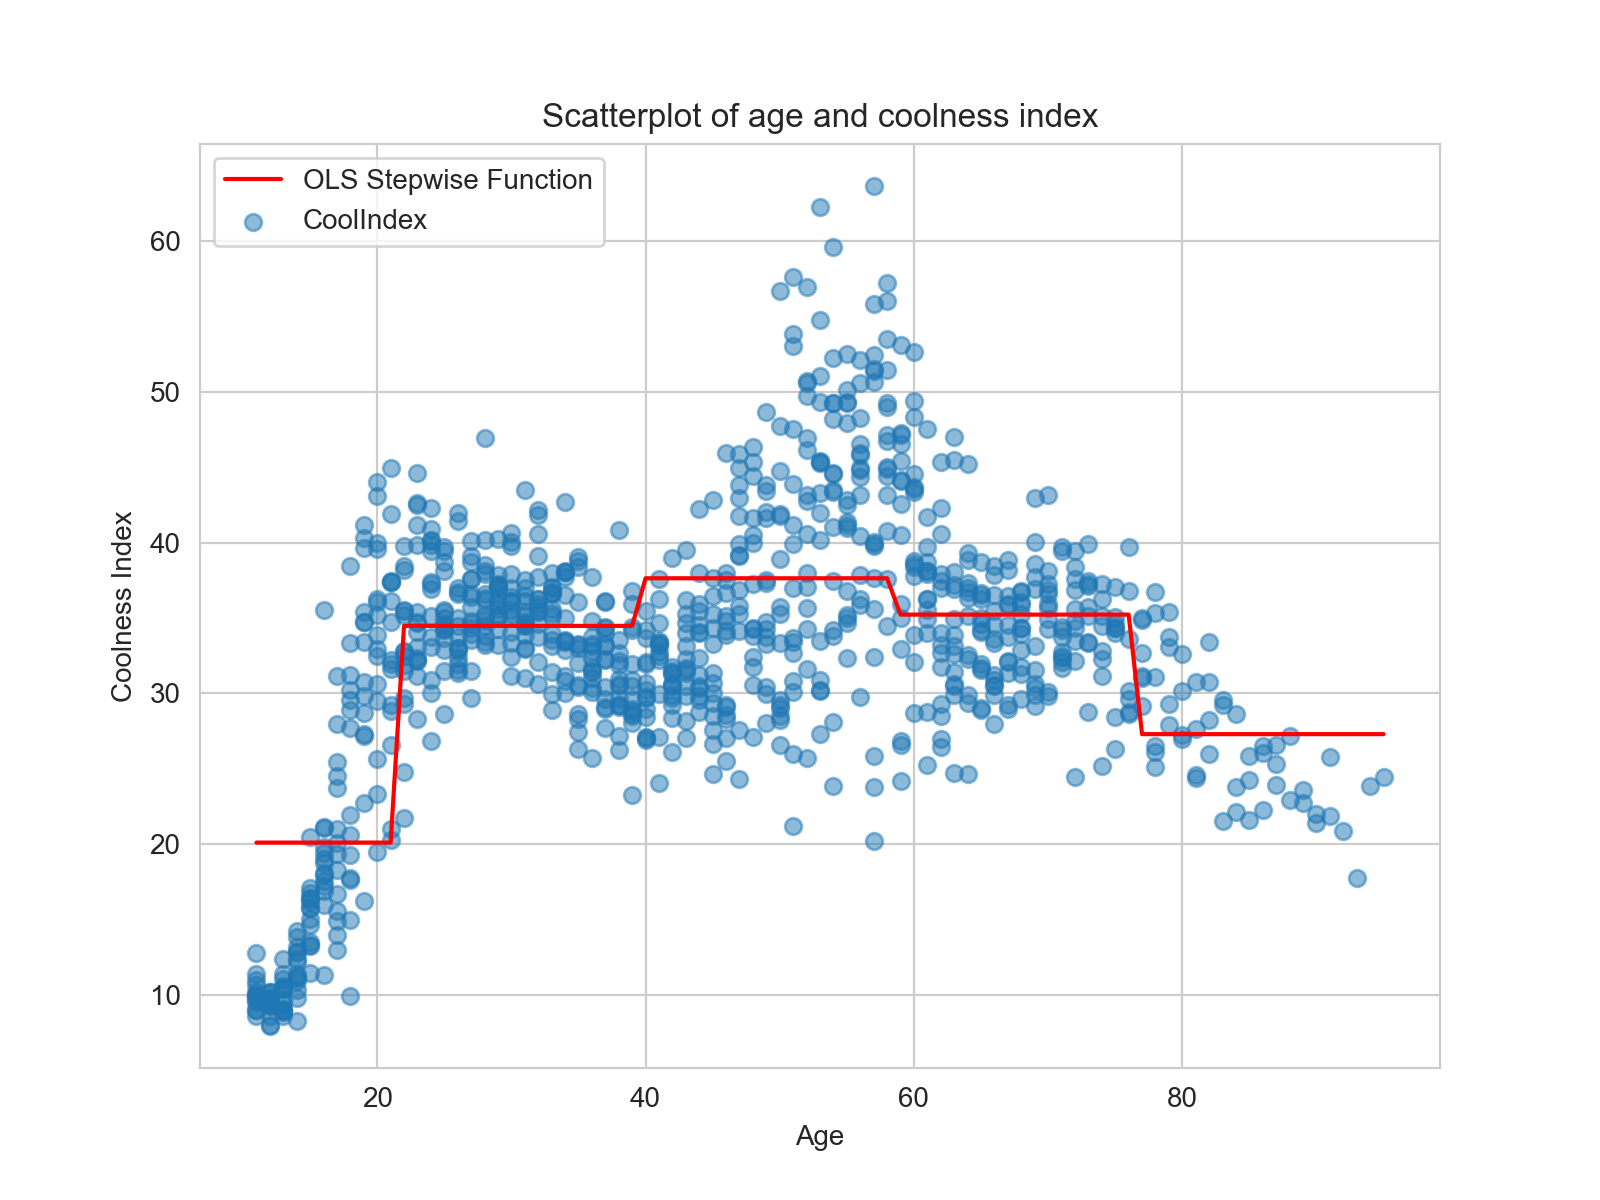

In [22]:
plt.scatter(df.Age,df.CoolIndex,alpha=0.5)
plt.plot(df.Age,res.predict(), color="r", label = "OLS Stepwise Function")
plt.legend(loc="upper left")
plt.xlabel("Age")
plt.ylabel("Coolness Index")
plt.title("Scatterplot of age and coolness index")
plt.show()

### (c) Fit a linear spline

<IPython.core.display.Javascript object>


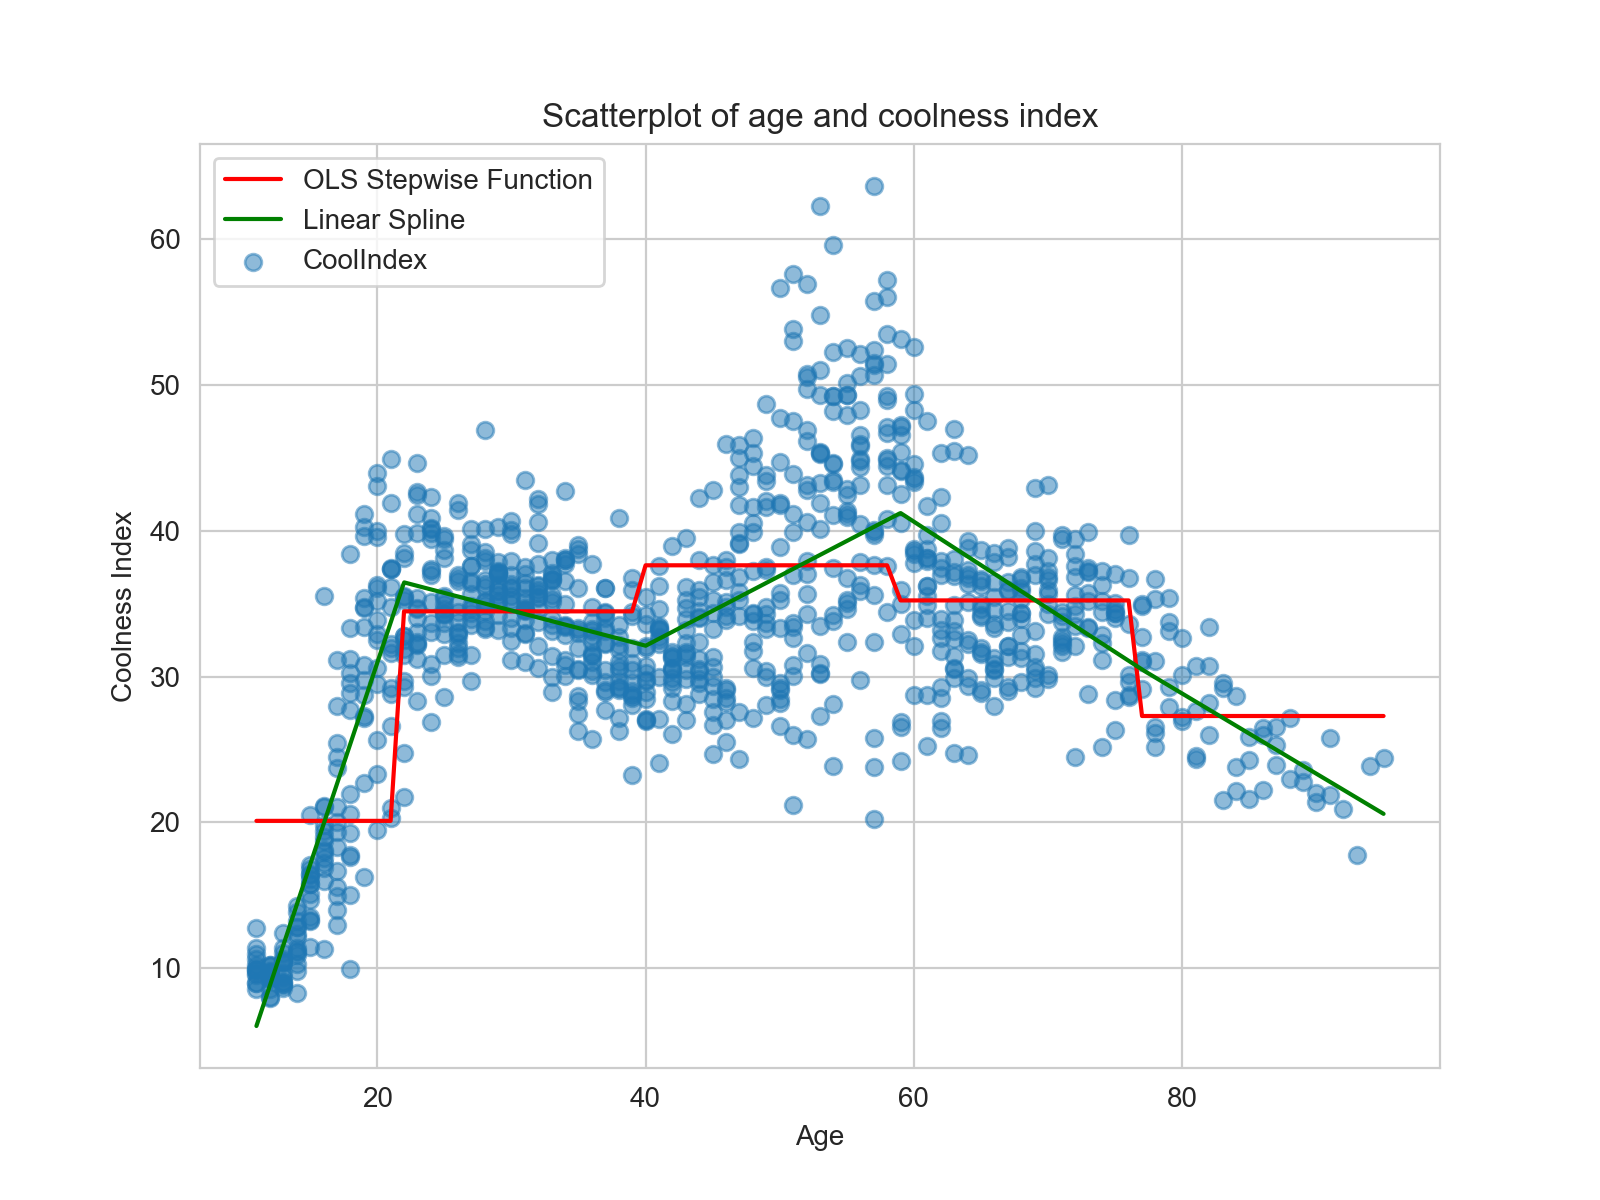

Text(0.5, 1.0, 'Scatterplot of age and coolness index')

In [23]:
t = np.array([22.0,40.0,59, 77.0])
df.sort_index(0, ascending=True, inplace=True)
grouped = df.groupby('Age', as_index = False).mean()
spl = LSQUnivariateSpline(grouped.Age.values, grouped.CoolIndex.values, t, k=1)
age_new = np.linspace(11,95,1000)

plt.scatter(df.Age, df.CoolIndex, alpha=0.5)
plt.plot(df.Age,res.predict(), color="r", label = "OLS Stepwise Function")
plt.plot(age_new, spl(age_new), color='g', label='Linear Spline')
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.legend(loc='upper left')
plt.title('Scatterplot of age and coolness index')

In [24]:
print("The predicted coolness of a 73-year old from the linear spline is:")
print(spl(73))

The predicted coolness of a 73-year old from the linear spline is:
32.86784862349653


### (d) Fit a cubic spline

<IPython.core.display.Javascript object>


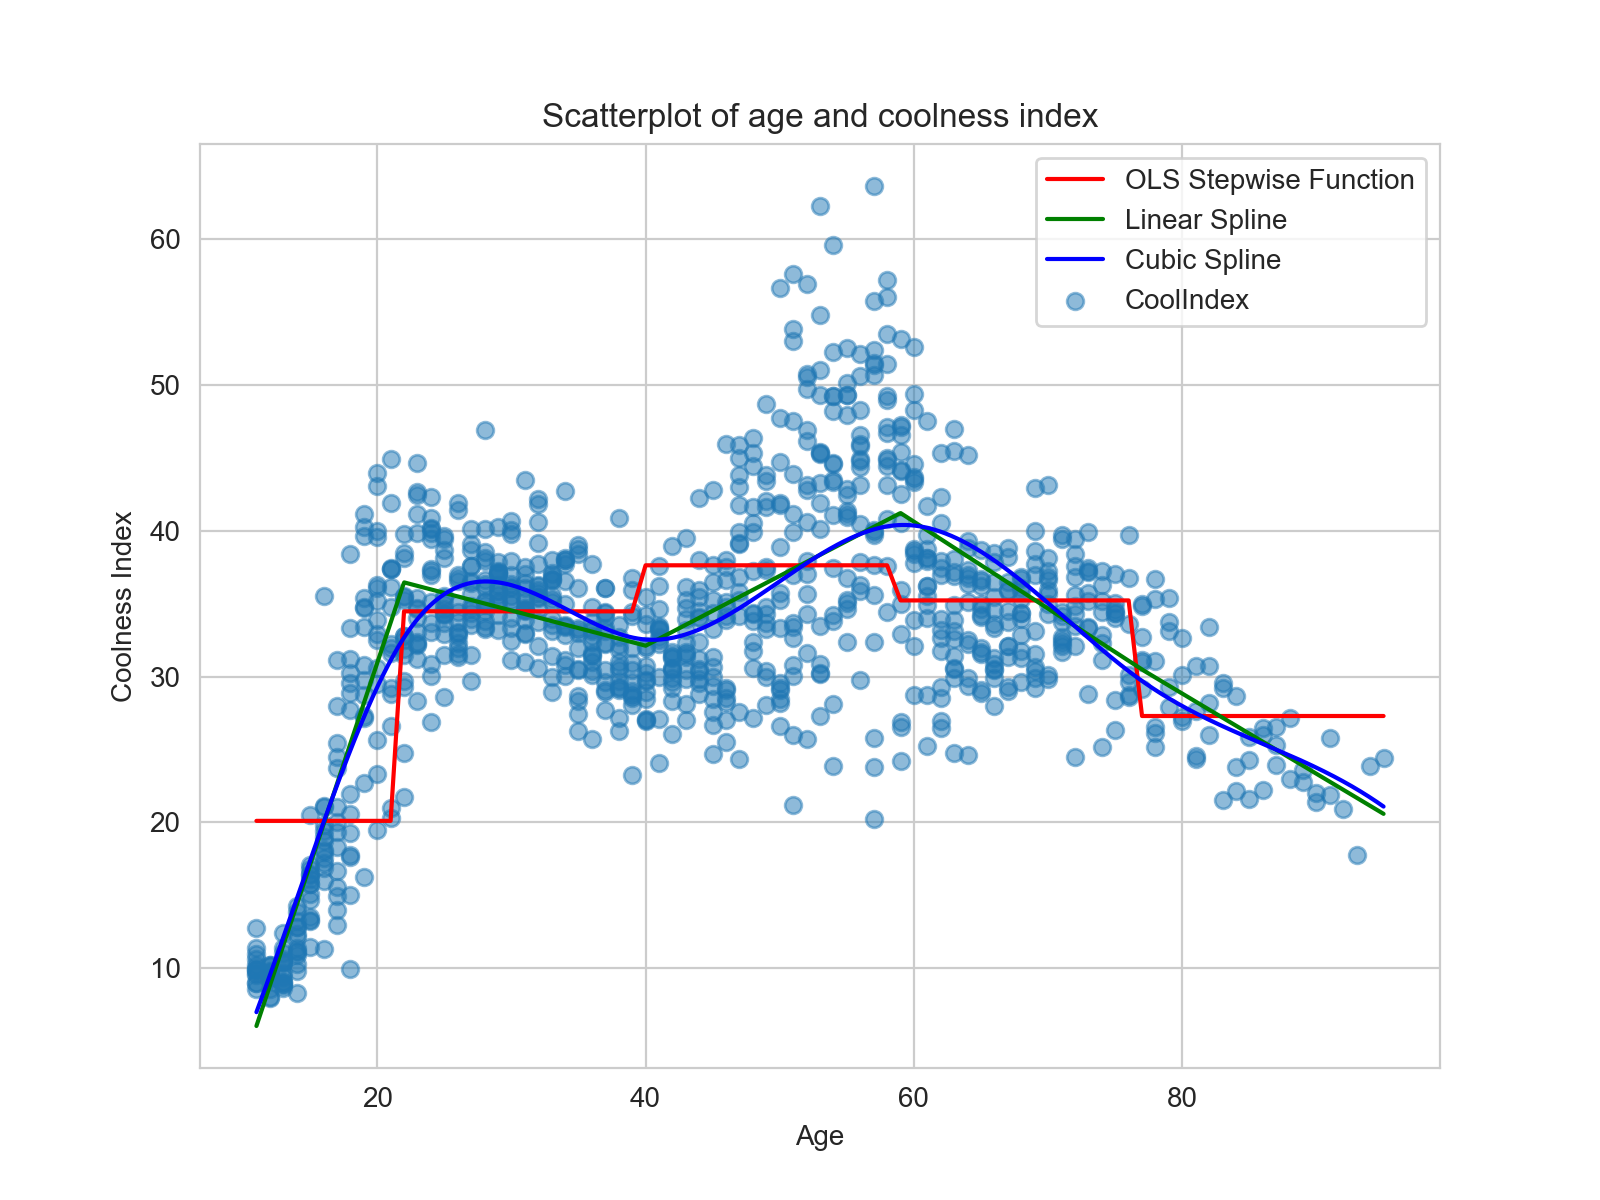

Text(0.5, 1.0, 'Scatterplot of age and coolness index')

In [25]:
spl2 = LSQUnivariateSpline(grouped.Age.values, grouped.CoolIndex.values, t, k=3)
plt.scatter(df.Age, df.CoolIndex, alpha=0.5)
plt.plot(df.Age,res.predict(), color="r", label = "OLS Stepwise Function")
plt.plot(age_new, spl(age_new), color='g', label='Linear Spline')
plt.plot(age_new, spl2(age_new), 'b', label='Cubic Spline')
plt.xlabel('Age')
plt.ylabel('Coolness Index')
plt.legend(loc='upper right')
plt.title('Scatterplot of age and coolness index')

In [26]:
print("The predicted coolness of a 73-year old from the cubic spline is:")
print(spl2(73))

The predicted coolness of a 73-year old from the cubic spline is:
32.642301066279764
